In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.io as pio
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import plotly.express as px

In [32]:
# Load the data
data = pd.read_csv('reshaped_data.csv')

In [34]:
print(data.shape)

(1535040, 6)


Year,Source_Filename,emissions,Country,Country_Code,Industry

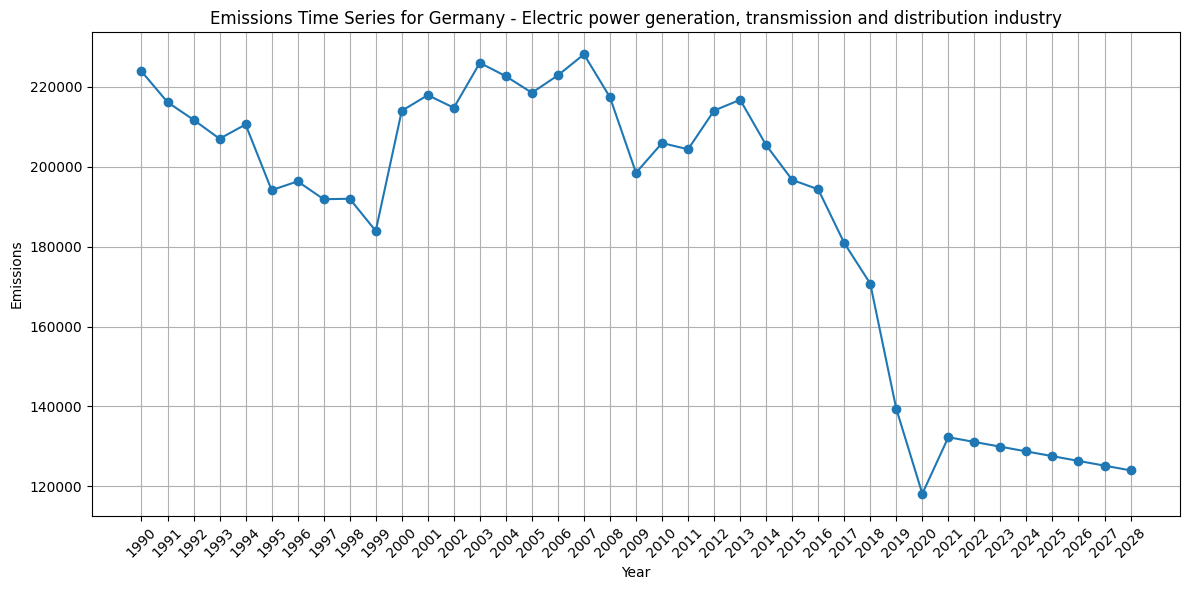

In [3]:
# Ensure 'Year' is of type integer for proper sorting
data['Year'] = data['Year'].astype(int)

# Aggregate emissions data by year, country, and industry
time_series_data = data.groupby(['Year', 'Country', 'Country_Code', 'Industry']).agg({'emissions': 'sum'}).reset_index()

# Example: Plot time series for a specific country and industry
def plot_time_series(country, industry):
    subset = time_series_data[(time_series_data['Country'] == country) & (time_series_data['Industry'] == industry)]
    plt.figure(figsize=(12, 6))
    plt.plot(subset['Year'], subset['emissions'], marker='o', linestyle='-')
    plt.title(f'Emissions Time Series for {country} - {industry}')
    plt.xlabel('Year')
    plt.ylabel('Emissions')
    plt.grid(True)
    plt.xticks(subset['Year'], rotation=45)
    plt.tight_layout()
    plt.show()

# Example usage: Plot time series for 'Cyprus' and 'Other services product'
plot_time_series('Germany', 'Electric power generation, transmission and distribution industry')


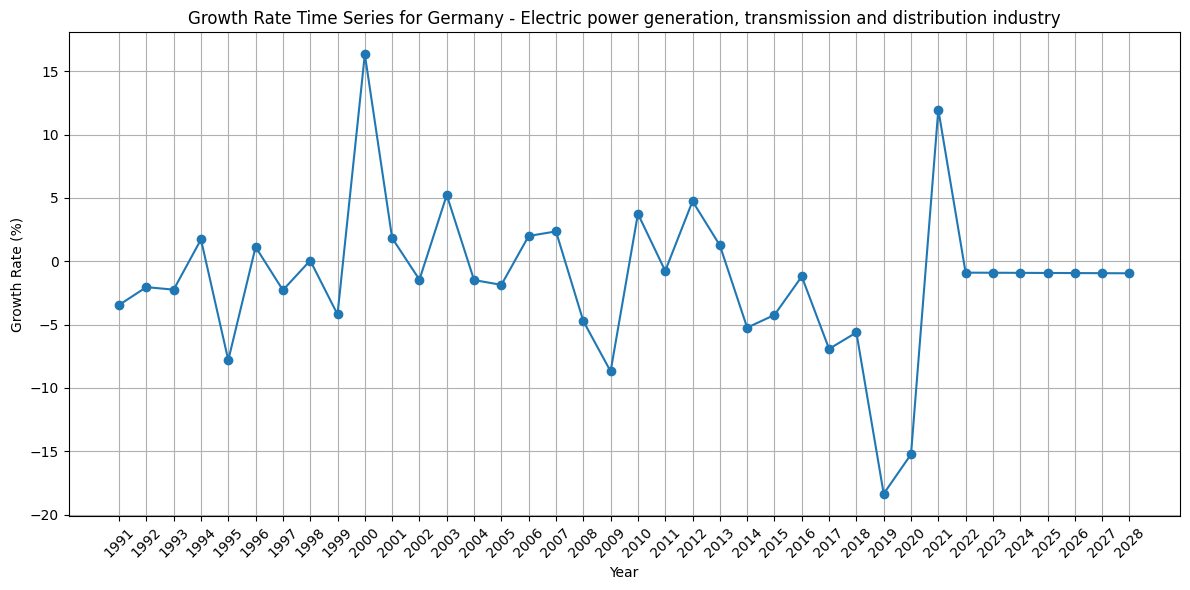

In [4]:
# Add columns for the previous year's emissions to calculate growth
data = data.sort_values(by=['Country', 'Industry', 'Year'])
data['Prev_Year_Emissions'] = data.groupby(['Country', 'Industry'])['emissions'].shift(1)

# Calculate year-on-year growth rate
data['Growth_Rate'] = (data['emissions'] - data['Prev_Year_Emissions']) / data['Prev_Year_Emissions'] * 100

# Drop rows where previous year data is missing (e.g., first year for each group)
data = data.dropna(subset=['Prev_Year_Emissions'])

# Example: Analyze and plot growth trends for a specific country and industry
def plot_growth_trends(country, industry):
    subset = data[(data['Country'] == country) & (data['Industry'] == industry)]
    plt.figure(figsize=(12, 6))
    plt.plot(subset['Year'], subset['Growth_Rate'], marker='o', linestyle='-')
    plt.title(f'Growth Rate Time Series for {country} - {industry}')
    plt.xlabel('Year')
    plt.ylabel('Growth Rate (%)')
    plt.grid(True)
    plt.xticks(subset['Year'], rotation=45)
    plt.tight_layout()
    plt.show()

# Example usage: Plot growth trends for 'Cyprus' and 'Other services product'
plot_growth_trends('Germany', 'Electric power generation, transmission and distribution industry')


In [29]:

# Define the function to compare emissions across countries for a specific industry
def compare_countries(industry):
    subset = data[data['Industry'] == industry]
    pivot_table = subset.pivot_table(index='Year', columns='Country', values='emissions', aggfunc='sum').reset_index()
    industry_long = pivot_table.melt(id_vars='Year', var_name='Country', value_name='Emissions')
    
    # Create interactive plot with plotly
    fig = px.line(industry_long, x='Year', y='Emissions', color='Country', title=f'Comparison of Emissions for {industry}')
    
    # Customize the layout
    fig.update_layout(
        xaxis_title='Year',
        yaxis_title='Emissions',
        legend_title='Country',
        width=1000,
        height=600
    )
    
    # Show the plot
    fig.show()

# Example usage: Compare emissions for 'Electric power generation, transmission and distribution industry' across countries
compare_countries('Electric power generation, transmission and distribution industry')

### Aggregate emissions data

In [5]:
# Group by year and country, summing emissions
country_emissions = data.groupby(['Year', 'Country'])['emissions'].sum().reset_index()

# Group by year and industry, summing emissions
industry_emissions = data.groupby(['Year', 'Industry'])['emissions'].sum().reset_index()


In [6]:
country_emissions

,Year,Country,emissions
0,1990,Afghanistan,13181.903475
1,1990,Albania,10505.512795
2,1990,Algeria,127449.125887
3,1990,Angola,31022.228623
4,1990,Argentina,225362.322382
...,...,...,...
6391,2028,Viet Nam,558869.638346
6392,2028,Yemen Arab Republic/Yemen,44782.100864
6393,2028,Yugoslavia/Serbia,0.000000
6394,2028,Zambia,26521.184599


In [7]:
industry_emissions

,Year,Industry,emissions
0,1990,Administrative services industry,7378.743837
1,1990,Administrative services product,0.000000
2,1990,Air transport industry,444362.688137
3,1990,Air transport product,0.000000
4,1990,Alcoholic and other beverages industry,40818.879836
...,...,...,...
9355,2028,"Water collection, treatment and supply; sewera...",0.000000
9356,2028,Water transport industry,314898.862808
9357,2028,Water transport product,0.000000
9358,2028,Wholesale and retail trade; repair of motor ve...,113947.345097


### Pivot tables for visualization

In [19]:
# Pivot table for country emissions
country_pivot = country_emissions.pivot(index='Year', columns='Country', values='emissions')

# Pivot table for industry emissions
industry_pivot = industry_emissions.pivot(index='Year', columns='Industry', values='emissions')


In [28]:

# Pivot table for country emissions
country_pivot = data.pivot_table(index='Year', columns='Country', values='emissions', aggfunc='sum')

# Reset index to use Year as a column for plotting
country_pivot.reset_index(inplace=True)

# Melt the DataFrame to long format
country_long = country_pivot.melt(id_vars='Year', var_name='Country', value_name='Emissions')

# Create interactive plot with plotly
fig = px.line(country_long, x='Year', y='Emissions', color='Country', title='Emissions Over Time by Country')

# Show the plot
fig.show()

In [27]:


# Pivot table for industry emissions
industry_pivot = data.pivot_table(index='Year', columns='Industry', values='emissions', aggfunc='sum')

# Reset index to use Year as a column for plotting
industry_pivot.reset_index(inplace=True)

# Melt the DataFrame to long format
industry_long = industry_pivot.melt(id_vars='Year', var_name='Industry', value_name='Emissions')

# Create interactive plot with plotly
fig = px.line(industry_long, x='Year', y='Emissions', color='Industry', title='Emissions Over Time by Industry')

# Show the plot
fig.show()
